# SeaSoar Processing

1. Load data
2. Identify upcasts and downcasts
3. Flag spurious pressure/data points by moving median filter
4. Bin sensor data to regular pressures
5. Flag outliers in signals

In [25]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


In [26]:
input.dir = '../../Models/SeaSoar/SeaSoar2/'

files = list.files(input.dir)
files = files[grepl('.mat', files)]
files = files[!grepl('.rdata', files)]
length(files)

[1] 46

In [27]:
get.data = function(input.dir, file) {
    data = readMat(paste0(input.dir, file), fixNames = TRUE)
    names = unlist(dimnames(data$data)[1])

    ## Partition up datea
    eng = as.data.frame(data$data[2:12])
    sensor = as.data.frame(data$data[13:36])
    colnames(sensor) = names[13:36]
    colnames(eng) = names[2:12]
    
    sensor$time = seq(from = eng$time[1], by = 1/24, length.out = nrow(sensor))
    
    return(list(eng = eng, sensor = sensor))
}

#### Flag Outliers in pressure
flag.p.outliers = function(data, dp = 0.5, verbose = TRUE, window = 25) {
    l = which(abs(data$sensor$p - runmed(data$sensor$p, window)) > dp)
    
    data$sensor$p.FLAG = 1 # keep
    data$sensor$p.FLAG[l] = 3 # reject
    
    if (verbose) {
        n = length(l)
        perc = floor(length(l) / nrow(data$sensor)*1000)/10
        
        print(paste0('Flagging identified ', n, ' (', perc, '%) outliers.'))
    }
    data
}

#### Bin Data by pressure and time
bin.pt = function(data, dp = 1, secs = 10) {
    i = 1
    while (i < nrow(data$sensor)) {
        l = which(abs(data$sensor$p - data$sensor$p[i]) + abs(data$sensor$time - data$sensor$time[i]) / secs < dp / 2 &
                 data$sensor$p.FLAG == 1)
        temp = apply(data$sensor[l,], 2, function(x) {mean(x, na.rm = TRUE)})
        
        if (length(l) > 1) {
            data$sensor[i,] = temp
            l = l[l != i]
            
            data$sensor = data$sensor[-l,]
        }
        i = i + 1
    }
    
    data
}

#### Bin Data by pressure
bin.p = function(data, dp = 1) {
    data$sensor = data$sensor[which(data$sensor$p.FLAG == 1),]
    data$sensor$p = floor((data$sensor$p + 0.5) / dp)
    data$sensor$n.bin = 1
    
    i = 1
    while (i < nrow(data$sensor)) {
        delta.p = abs(diff(data$sensor$p[i:nrow(data$sensor)]))  # i refenced
        
        ## Find entries to average across
        l = which(cumsum(delta.p) == 0)
        l = c(i, l + i)
        
        temp = as.numeric(apply(data$sensor[l,], 2, function(x) {median(x, na.rm = TRUE)}))
        
        ## Update values and some housekepping
        if (length(l) > 1 & length(temp) == ncol(data$sensor)) { ## Need to update values
            data$sensor[i,] = temp
            data$sensor$n.bin[i] = length(l)
            
            l = l[l != i]
            data$sensor = data$sensor[-l,] ## Remove other values
            delta.p = delta.p[-l]
        }
        i = i + 1
    }
    ## Finalize and return averaged data
    data$sensor$p = data$sensor$p * dp
    data
}

In [4]:
check.bin = function(data, l = c(1000:135000)) {
    plot(data$sensor$time[l], data$sensor$p[l], type='l', ylab='Pressure', xlab='Time', ylim=c(100,0), yaxs='i')
    points(bin.data$sensor$time, bin.data$sensor$p, pch=4, cex=1.5, col='blue')
}

In [30]:
preprocess.files = function(input.dir, files, verbose = FALSE) {
    for (f in 1:length(files)) {
        if (verbose) {
            print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))
        }
        
        data = get.data(input.dir, files[f])
        data = flag.p.outliers(data)
        n.before = nrow(data$sensor)
        
        if (verbose) {print('Binning the data.')}
        data = bin.p(data, 5)
        
        if (verbose) {print('Checkpoint Saved.')}
        if (verbose) {print('')}
        
        save(data, file = paste0('RStates/SeaSoar/Seasoar2-binned-low-', files[f], '.rdata'))
        
        if (verbose) {
            print(paste0('Number of Sensor Records before binning: ', n.before))
            print(paste0('Number of Sensor Records after binning: ', nrow(data$sensor)))
            print(paste0('(', floor(nrow(data$sensor)/n.before * 1000) / 10, '%)'))
        }
        print('')
    }
}

load.rstate = function(input.dir, files, verbose = TRUE) {
    compiled.data = NULL
    
    for (f in 1:length(files)) {
        if (verbose) {print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))}
        load(file = paste0('RStates/SeaSoar/Seasoar2-binned-low-', files[f], '.rdata'))
        
        if (is.null(compiled.data)) {
            compiled.data = data
        } else {
            compiled.data$sensor = rbind(compiled.data$sensor, data$sensor)
            compiled.data$eng = rbind(compiled.data$eng, data$eng)
        }
        print(nrow(data$sensor))
    }
    compiled.data
}

In [ ]:
preprocess.files(input.dir, files, verbose = TRUE)

[1] "Starting file: FLT_DAT001.mat (1 of 46)"
[1] "Flagging identified 4808 (3%) outliers."
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 5193"
[1] "(3.3%)"
[1] ""
[1] "Starting file: FLT_DAT002.mat (2 of 46)"
[1] "Flagging identified 4492 (2.8%) outliers."
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 6394"
[1] "(4.1%)"
[1] ""
[1] "Starting file: FLT_DAT003.mat (3 of 46)"
[1] "Flagging identified 3356 (2.1%) outliers."
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 6421"
[1] "(4.1%)"
[1] ""
[1] "Starting file: FLT_DAT004.mat (4 of 46)"
[1] "Flagging identified 7082 (4.5%) outliers."
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records b

Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"

[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 6431"
[1] "(4.1%)"
[1] ""
[1] "Starting file: FLT_DAT01F.mat (31 of 46)"
[1] "Flagging identified 2921 (1.8%) outliers."
[1] "Binning the data."


Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"imaginary parts discarded in coercion"Warning message in bin.p(data, 5):
"im

In [7]:
data = load.rstate(input.dir, files)

[1] "Starting file: FLT_DAT001.mat (1 of 46)"
[1] 25636
[1] "Starting file: FLT_DAT002.mat (2 of 46)"
[1] 32904
[1] "Starting file: FLT_DAT003.mat (3 of 46)"
[1] 31622
[1] "Starting file: FLT_DAT004.mat (4 of 46)"
[1] 30884
[1] "Starting file: FLT_DAT005.mat (5 of 46)"
[1] 33684
[1] "Starting file: FLT_DAT006.mat (6 of 46)"
[1] 35406
[1] "Starting file: FLT_DAT007.mat (7 of 46)"
[1] 33722
[1] "Starting file: FLT_DAT008.mat (8 of 46)"
[1] 31938
[1] "Starting file: FLT_DAT009.mat (9 of 46)"
[1] 33452
[1] "Starting file: FLT_DAT00A.mat (10 of 46)"
[1] 32679
[1] "Starting file: FLT_DAT00B.mat (11 of 46)"
[1] 30926
[1] "Starting file: FLT_DAT00C.mat (12 of 46)"
[1] 32338
[1] "Starting file: FLT_DAT00D.mat (13 of 46)"
[1] 29354
[1] "Starting file: FLT_DAT00E.mat (14 of 46)"
[1] 34393
[1] "Starting file: FLT_DAT00F.mat (15 of 46)"
[1] 28879
[1] "Starting file: FLT_DAT010.mat (16 of 46)"
[1] 27748
[1] "Starting file: FLT_DAT011.mat (17 of 46)"
[1] 26983
[1] "Starting file: FLT_DAT012.mat (18 o

In [8]:
conv.time = function(x, tz = 'UTC') {
    as.POSIXct(x, origin="1970-01-01", tz = tz)
}

add.times = function(data, tz = 'UTC') {
    data$sensor$time.real = as.POSIXct(data$sensor$time, origin="1970-01-01", tz = tz)
    data$eng$time.real = as.POSIXct(data$eng$time, origin="1970-01-01", tz = tz)
    
    data
}

In [9]:
for (i in 1:ncol(data$sensor)) {
    data$sensor[,i] = as.numeric(data$sensor[,i])
}
str(data)

Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"Warning message in eval(expr, envir, enclos):
"imaginary parts discarded in coercion"

List of 2
 $ eng   :'data.frame':	294146 obs. of  11 variables:
  ..$ lat        : num [1:294146] 33.5 33.5 33.5 33.5 33.5 ...
  ..$ lon        : num [1:294146] -123 -123 -123 -123 -123 ...
  ..$ time       : num [1:294146] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:294146] 342 340 339 338 338 ...
  ..$ sog        : num [1:294146] 1.6 1.5 1.5 1.5 1.7 1.7 1.8 1.7 1.6 1.5 ...
  ..$ heading    : num [1:294146] 345 345 345 345 345 ...
  ..$ sow        : num [1:294146] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:294146] 3277 3277 3277 3277 3277 ...
  ..$ moogdrive  : num [1:294146] 42 42 42 42 42 42 42 42 42 42 ...
  ..$ moogmonitor: num [1:294146] -108 -108 -108 -108 -108 ...
  ..$ tension    : num [1:294146] 4572 5199 5437 5502 5502 ...
 $ sensor:'data.frame':	1213975 obs. of  27 variables:
  ..$ t1         : num [1:1213975] 17.2 17.2 17.2 17.2 17.2 ...
  ..$ t2         : num [1:1213975] 17.2 17.2 17.3 17.3 17.2 ...
  ..$ p          : n

In [10]:
data = add.times(data)

In [11]:
add.direction = function(data, p.min = 8, p.max = 250) {
    ## value codes
    ##   -1 = downcast
    ##   +1 = upcast
    ##    0 = ambiguous/outside bounds
    
    data$sensor$direction = 0
    dp = diff(data$sensor$p)
    
    l = which(dp < 0) # getting shallower
    data$sensor$direction[l+1] = 1
    
    l = which(dp > 0) # getting depper
    data$sensor$direction[l+1] = -1
    
    data
}

In [12]:
data = add.direction(data)

In [13]:
align.seasoar = function(data) {
    data$sensor$lat = 0
    data$sensor$lon = 0
    
    for (i in 1:nrow(data$sensor)) {
        l = which.min(abs(data$sensor$time[i] - data$eng$time))
        data$sensor$lat[i] = data$eng$lat[l]
        data$sensor$lon[i] = data$eng$lon[l]
    }
    data
}

In [14]:
data = align.seasoar(data)

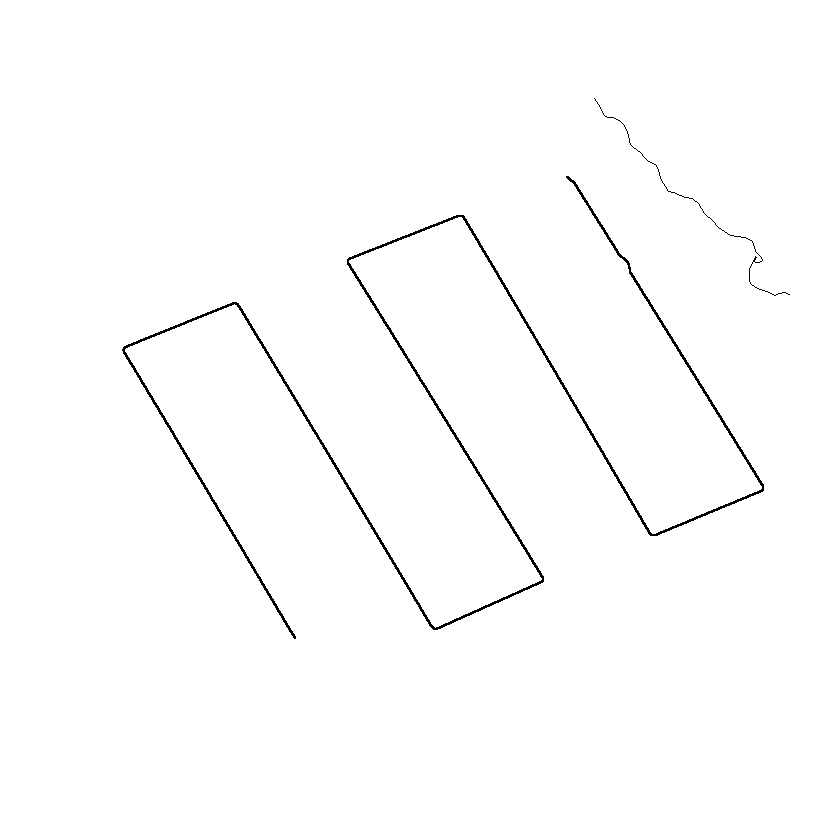

In [18]:
plot.map(data$sensor$lat, lon = data$sensor$lon, pch=20, cex=0.2, col='black')

In [13]:
get.mld = function(data, rho = 0.1) {
    mld = data.frame(time = 0, lat = 0, lon = 0, mld = 0, stringsAsFactors = FALSE)
    
    ## Trim data to between 5db and 100db
    data$sensor = data$sensor[data$sensor$p > 5 & data$sensor$p < 100,]
    
    ## Find all the 10meter points on the downcast
    l = which(data$sensor$p == 10 & data$sensor$direction == -1)
    
    ## l should only include entries from different casts: here 10 minutes apart.
    dt = as.numeric(difftime(data$sensor$time.real[l], data$sensor$time.real[l[1]], units='mins'))
    l = l[c(1, which(diff(dt) > 10))]
    
    print(length(l))
    
    ## calculate mld and add to dataframe
    for (i in 1:length(l)) {
        t.10 = data$sensor$time.real[l[i]]
        rho.10 = data$sensor$sigma2[l[i]]
        
        ## define cast as within 3 minutes, downcast, pressure > 10, and afterwards
        l.time = which(as.numeric(difftime(data$sensor$time.real, t.10, unit='mins')) < 5 &
                       data$sensor$direction == -1 & data$sensor$p > 10 &
                       as.numeric(difftime(data$sensor$time.real, t.10, unit='mins')) > 0)
        
        if (length(l.time) > 15) {
            l.mld = min(which(data$sensor$sigma2[l.time] > rho.10 + rho))
            t.mld = data$sensor$time.real[l.time[l.mld]]

            eng = which.min(as.numeric(difftime(data$eng$time.real, t.10, units = 'mins'))^2)
            mld = rbind(mld, c(t.mld, data$eng$lat[eng], data$eng$lon[eng], data$sensor$p[l.time[l.mld]]))
        }
    }
    
    mld = mld[-1,]
    mld$time = conv.time(mld$time)
    mld
}

In [14]:
mld = get.mld(data, 0.1)
mld2 = get.mld(data, 0.2)

[1] 92
[1] 92


Warning message in min(which(data$sensor$sigma2[l.time] > rho.10 + rho)):
"no non-missing arguments to min; returning Inf"

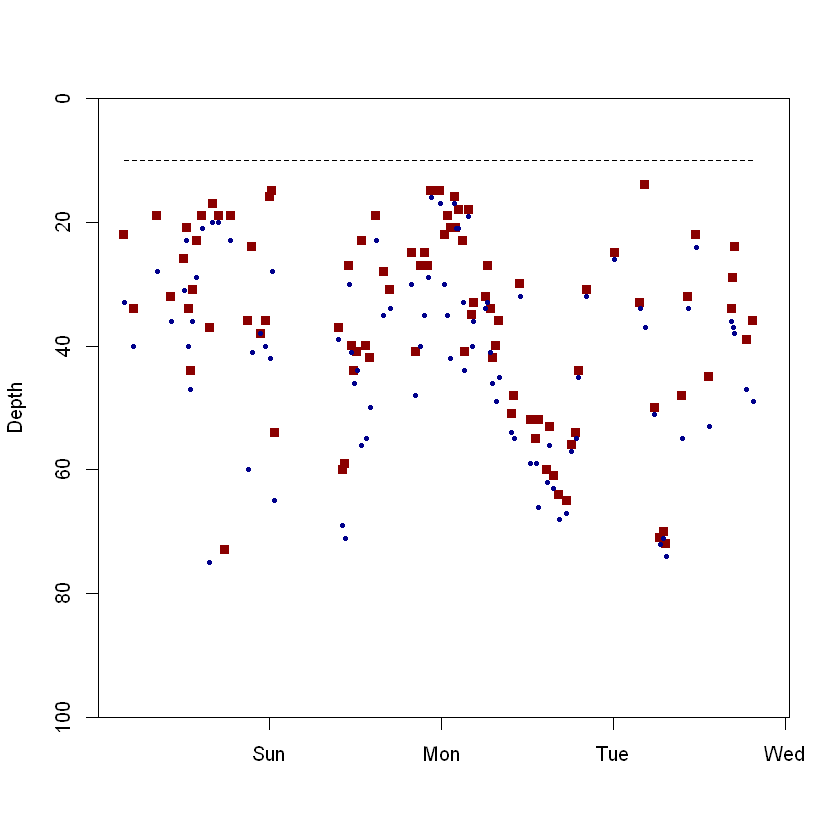

In [15]:
#plot(data$sensor$time.real, data$sensor$p, cex=0.1, pch=20, col=get.qual.pal(3)[data$sensor$direction+2],
#     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')
plot(data$sensor$time.real[c(1, nrow(data$sensor))], data$sensor$p[c(1, nrow(data$sensor))], cex=0.1, pch=20, col='white',
     ylim=c(100,0), yaxs='i', ylab='Depth', xlab='')

points(mld$time, mld$mld, pch=15, col='dark red')
points(mld2$time, mld2$mld, pch=16, col='dark blue', cex=0.5)
lines(c(min(mld$time), max(mld$time)), c(10,10), lty=2)

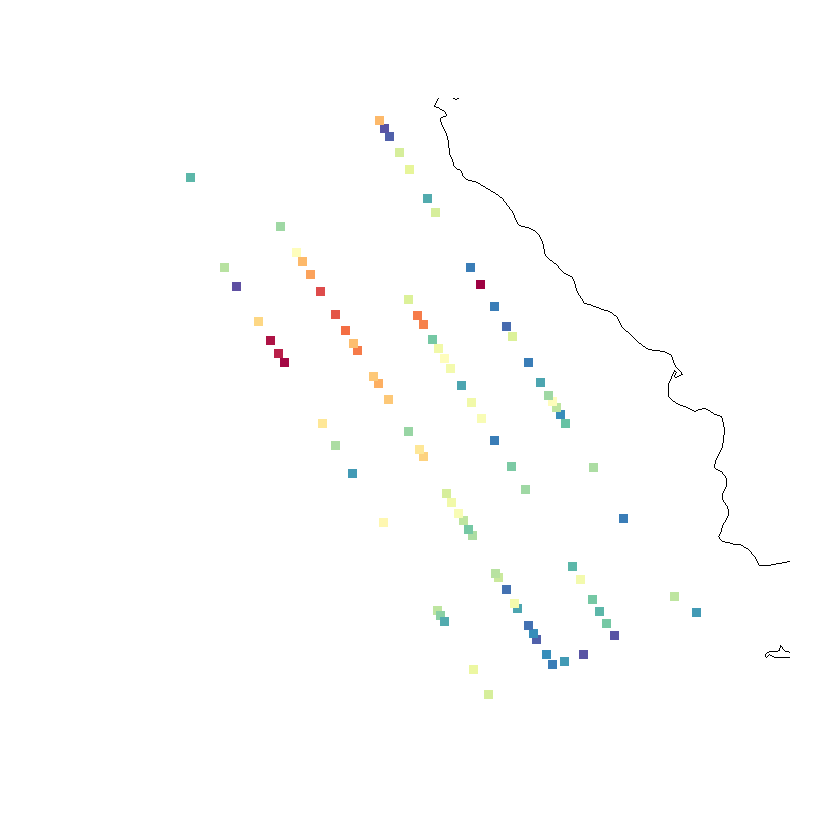

In [88]:
plot.map(lon = mld$lon, lat = mld$lat, main = 'SeaSoar MLDs', col = make.div.pal(mld$mld, 100), cex=1, pch=15)

In [17]:
seasoar2 = mld
save(seasoar2, file = 'RStates/SeaSoar2.MLD (0.1).rdata')

In [18]:
save(data, file='RStates/SeaSoar2.final.rdata')

---
# Review

In [19]:
plot.mld = function(mld, i, window = 3) {
    l = which(as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) < window &
              as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) >= -window &
             data$sensor$direction == -1)
    
    plot(data$sensor$sigma2[l], data$sensor$p[l], ylim=c(100,0), xlim=c(1023,1027), yaxs='i',
         pch=20, col='#00000050', cex=1, main=paste0(i, ' - ', length(l)), ylab='Depth', xlab='Density')
    
    lines(c(0,10000), rep(mld$mld[i], 2), lty=2, col='red')
    #lines(c(0,10000), rep(mld2$mld[i], 2), lty=1, col='red')
    lines(c(0,10000), rep(10, 2), lty=2, col='blue')
    
    text(1023, 80, mld$mld[i])
}

In [22]:
pdf('Output/SeaSoar1 - MLD Review (0.2).pdf')

par(mfrow=c(2,2))
for(i in 1:nrow(mld2)) {
    plot.mld(mld2, i)
}

dev.off()

png 
  2

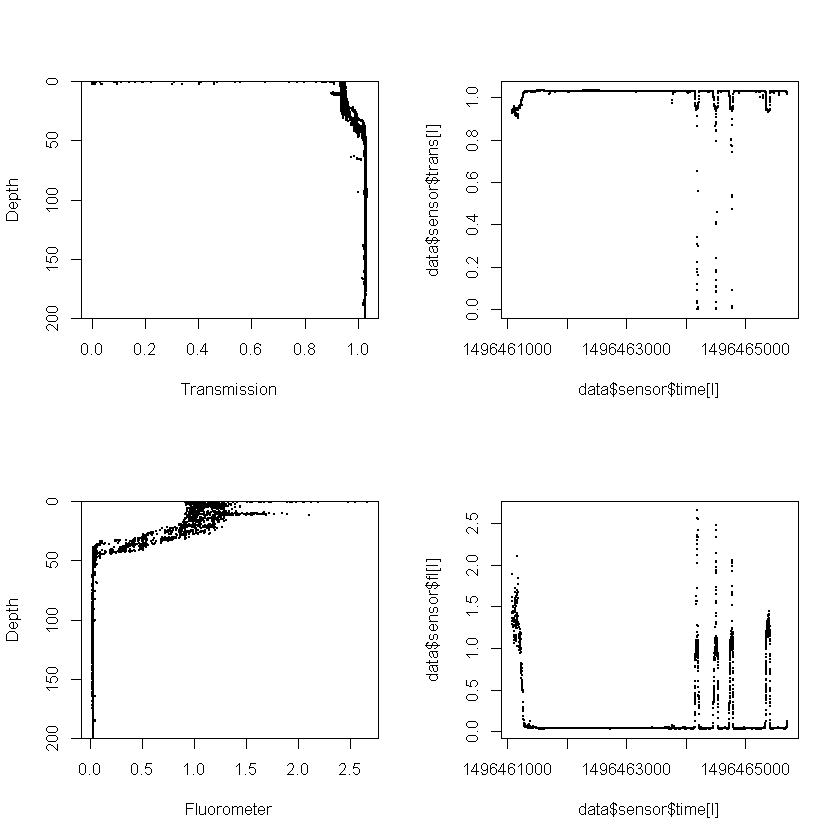

In [29]:
l = c(1:10000)

par(mfrow=c(2,2))
plot(data$sensor$trans[l], data$sensor$p[l], pch=20, cex=0.1, ylim=c(200,0), yaxs='i', ylab='Depth', xlab='Transmission')
plot(data$sensor$time[l], data$sensor$trans[l], pch=20, cex=0.1)

plot(data$sensor$fl[l], data$sensor$p[l], pch=20, cex=0.1, ylim=c(200,0), yaxs='i', ylab='Depth', xlab='Fluorometer')
plot(data$sensor$time[l], data$sensor$fl[l], pch=20, cex=0.1)

In [82]:
l = which(abs(data$sensor$p - 20) < 0.5)
lat = c()
lon = c()

for (i in 1:length(l)) {
    k = which.min(abs(data$eng$time - data$sensor$time[l[i]]))
    lat = c(lat, data$eng$lat[k])
    lon = c(lon, data$eng$lon[k])
}


In [57]:
## Check value at 35PSU, 10C
#### 274.61

O2sol = function(S=35, T=10) { ## umol Kg-1
    
    # convert T to scaled temperature
    Ts = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A.0 = 5.80871
    A.1 = 3.20291
    A.2 = 4.17887
    A.3 = 5.10006
    A.4 = -9.86643e-2
    A.5 = 3.80369
    
    B.0 = -7.01577e-3
    B.1 = -7.70028e-3
    B.2 = -1.13864e-2
    B.3 = -9.51519e-3
    
    C.0 = -2.75915e-7

    A.calc = A.0 + A.1*Ts + A.2*Ts^2 + A.3*Ts^3 + A.4*Ts^4 + A.5*Ts^5
    B.calc = B.0 + B.1*Ts + B.2*Ts^2 + B.3*Ts^3
    
    ## (umol / kg)
    exp(A.calc + S * B.calc + C.0 * S^2)
}

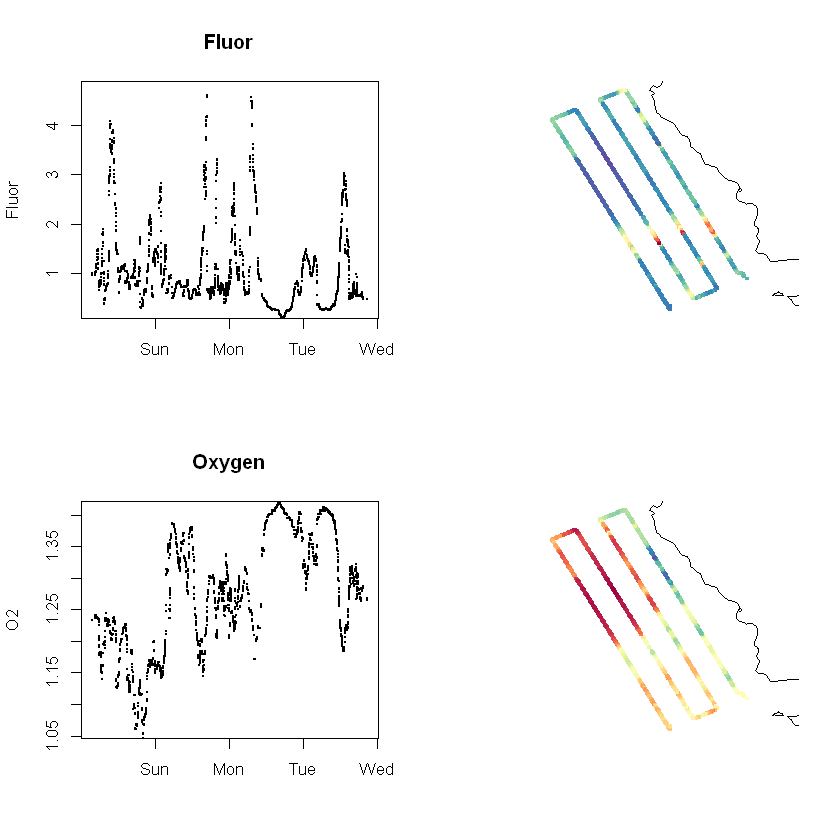

null device 
          1

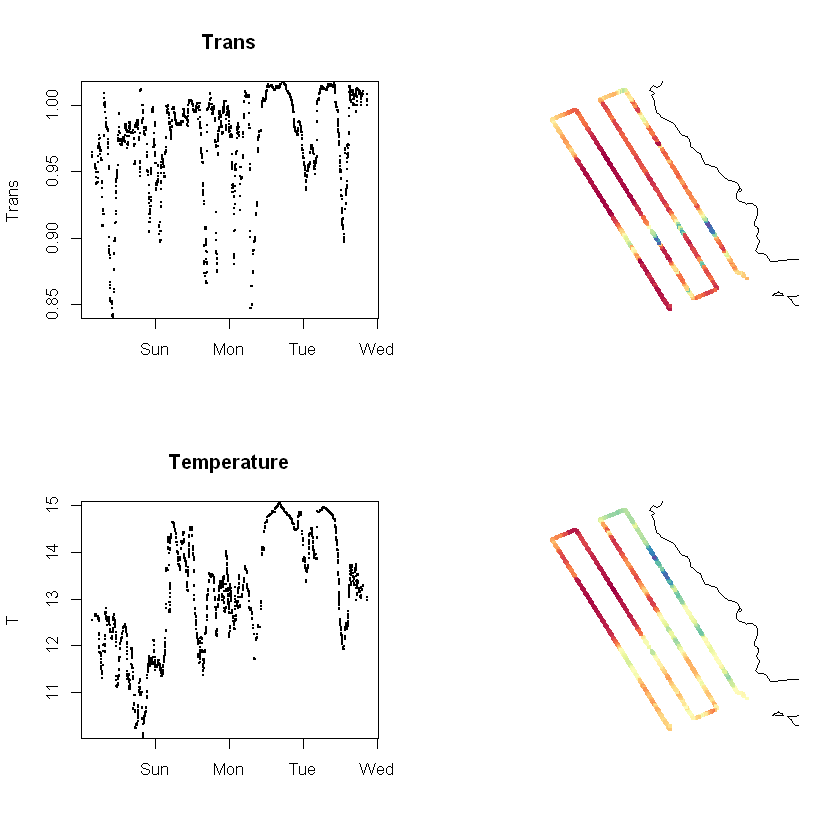

In [84]:
#pdf('Output/Seasoar - Values at depth (20m).pdf')
par(mfrow = c(2,2))

####
plot(data$sensor$time.real[l], runmed(data$sensor$fl[l],21), pch=20, cex=0.1, ylab='Fluor', xlab='',
     yaxs='i', main='Fluor')
plot.map(lon = lon, lat = lat, main='Fluor', col = make.div.pal(runmed(data$sensor$fl[l], 21), 100),
         pch=15, cex=0.5, zoom = 0)

####
plot(data$sensor$time.real[l], runmed(data$sensor$oxy[l],21),
     pch=20, cex=0.1, ylab='O2', xlab='', yaxs='i', main='Oxygen')
plot.map(lon = lon, lat = lat, main='Oxy',
         col = make.div.pal(runmed(data$sensor$oxy[l], 21), 100),
         pch=15, cex=0.5, zoom = 0)

####
plot(data$sensor$time.real[l], runmed(data$sensor$trans[l],21), pch=20, cex=0.1, ylab='Trans', xlab='',
     yaxs='i', main = 'Trans')
plot.map(lon = lon, lat = lat, main='Trans', col = make.div.pal(runmed(data$sensor$trans[l], 21), 100),
         pch=15, cex=0.5, zoom = 0)


####
plot(data$sensor$time.real[l], runmed(data$sensor$t1[l],21), pch=20, cex=0.1, ylab='T', xlab='',
     yaxs='i', main='Temperature')
plot.map(lon = lon, lat = lat, main='Temp', col = make.div.pal(runmed(data$sensor$t1[l], 21), 100),
         pch=15, cex=0.5, zoom = 0)

dev.off()

In [23]:
l = which(data$sensor$direction == -1)

out = data.frame(Time = data$sensor$time[l], Lat = data$sensor$lat[l], Lon = data$sensor$lon[l], Depth = data$sensor$p[l],
                T = data$sensor$t1[l], S = data$sensor$s1[l])

str(out)

'data.frame':	606813 obs. of  6 variables:
 $ Time : num  1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
 $ Lat  : num  33.5 33.5 33.5 33.5 33.5 ...
 $ Lon  : num  -123 -123 -123 -123 -123 ...
 $ Depth: num  7 7 7 7 7 7 7 7 7 7 ...
 $ T    : num  17.2 17.2 17.2 17.2 17.2 ...
 $ S    : num  33.1 33.1 33.1 33.1 33.1 ...


In [24]:
write.table(x = out, '../../Data/CCELTER_P1706 Seasoar2 (physical).csv')

In [21]:
head(out)

Time,Lat,Lon,Depth,T,S
1498507112,33.52615,-123.0551,7,17.22221,33.13953
1498507112,33.52615,-123.0551,6,17.22239,33.14069
1498507112,33.52615,-123.0551,7,17.22386,33.13994
1498507112,33.52615,-123.0551,6,17.22442,33.13807
1498507112,33.52615,-123.0551,7,17.24611,33.11990
1498507112,33.52615,-123.0551,6,17.25529,33.11332
